In [2]:
import expt
import matplotlib.pyplot as plt
import wandb
from expt import Hypothesis, Run
from expt.plot import GridPlot

api = wandb.Api()


def create_hypothesis(name, wandb_runs, source_metric_name=None, target_metric_name=None):
    runs = []
    for idx, run in enumerate(wandb_runs):
        wandb_run = run.history()
        if "videos" in wandb_run:
            wandb_run = wandb_run.drop(columns=["videos"], axis=1)
        if source_metric_name:
            wandb_run[target_metric_name] = wandb_run[source_metric_name]
        runs += [Run(f"seed{idx}", wandb_run)]
        
    return Hypothesis(name, runs)

class Runset:
    def __init__(self, name: str, filters: dict, entity: str, project: str, groupby: str = ""):
        self.name = name
        self.filters = filters
        self.entity = entity
        self.project = project
        self.groupby = groupby

    @property
    def runs(self):
        return wandb.Api().runs(path=f"{self.entity}/{self.project}", filters=self.filters)

    @property
    def report_runset(self):
        return wb.RunSet(
            name=self.name,
            entity=self.entity,
            project=self.project,
            filters={"$or": [self.filters]},
            groupby=[self.groupby] if len(self.groupby) > 0 else None,
        )


env_ids = [
    "BigFish",
    "BossFight",
    "CaveFlyer",
    "Chaser",
    "Climber",
    "CoinRun",
    "Dodgeball",
    "FruitBot",
    "Heist",
    "Jumper",
    "Leaper",
    "Maze",
    "Miner",
    "Ninja",
    "Plunder",
    "StarPilot",
]

/home/clemens/miniconda3/envs/enn/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/clemens/miniconda3/envs/enn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BigFish


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


BossFight
CaveFlyer
Chaser
Climber
CoinRun
Dodgeball
FruitBot
Heist
Jumper
Leaper
Maze
Miner
Ninja
Plunder


KeyboardInterrupt: 

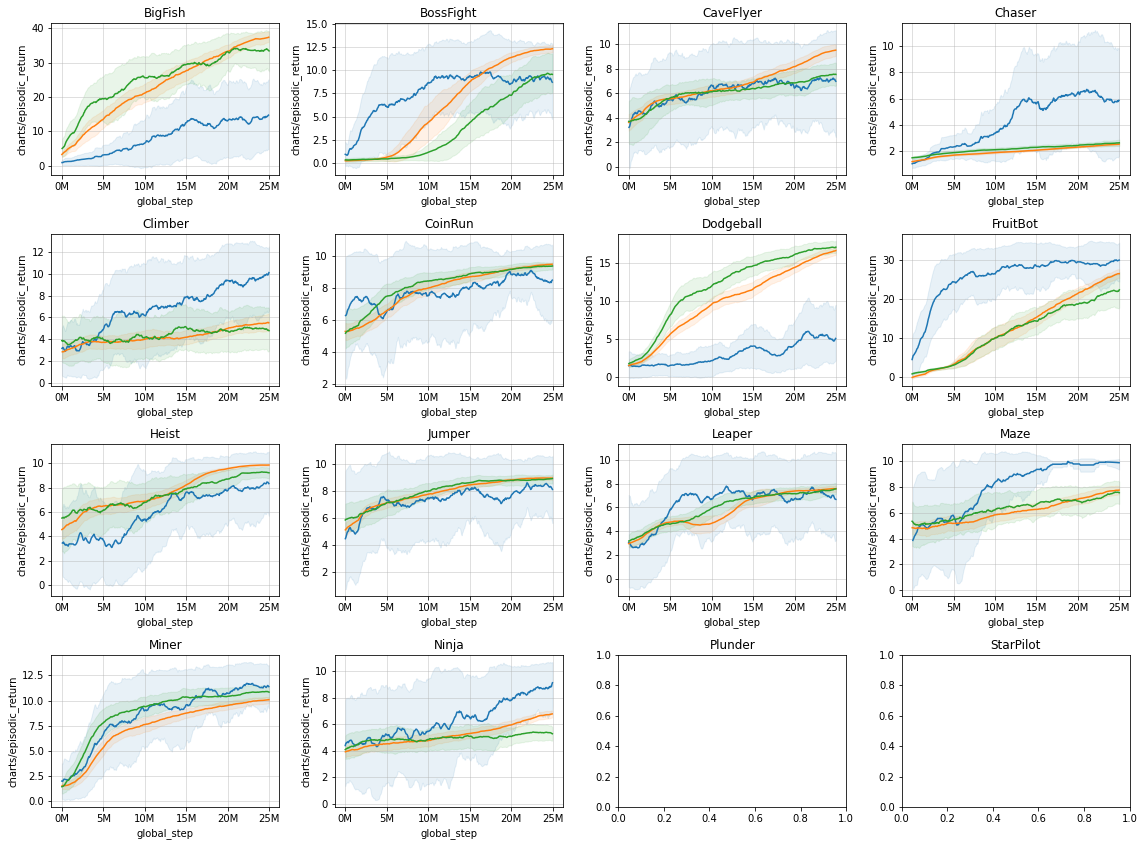

In [2]:
g = GridPlot(y_names=env_ids)
blocks = []

for env_id in env_ids:
    # NOTE: this is where to change things
    runset1 = Runset(
        name="IMPALA",
        filters={"$and": [{"config.env_id.value": env_id.lower()}, {"config.exp_name.value": "ppo_procgen"}]},
        entity="cswinter",
        project="cleanRL",
        groupby="env_id",
    )
    runset2 = Runset(
        name="RogueNet",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    # "$lt": '2022-03-09T10',
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221010-010215-procgen-baselines-mode=easy-env={env_id}"},
            ]
        },
        entity="entity-neural-network",
        project="enn-ppo",
        groupby="base_name",
    )
    runset3 = Runset(
        name="ENN default",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221102-152926-procgen-defaulthps-env={env_id}-mode=easy"},
            ]
        },
        entity="entity-neural-network",
        project="enn-ppo",
        groupby="base_name",
    )

    ex = expt.Experiment("Comparison of PPO")
    h = create_hypothesis(runset1.name, runset1.runs)
    ex.add_hypothesis(h)
    print(env_id)
    h2 = create_hypothesis(runset2.name, runset2.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h2)
    h3 = create_hypothesis(runset3.name, runset3.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h3)
    ex.plot(
        ax=g[env_id],
        title=env_id,
        # x="_runtime",
        x="global_step",
        y="charts/episodic_return",
        err_style="band",
        std_alpha=0.1,
        rolling=50,
        n_samples=400,
        legend=False,
    )

g.add_legend(ax=g.axes[-1, -1], loc="upper left", bbox_to_anchor=(0, 1))
# Some post-processing with matplotlib API so that the plot looks nicer
for ax in g.axes_active:
    ax.xaxis.set_label_text("")
    ax.yaxis.set_label_text("")
# Nontransparent background
g.fig.patch.set_alpha(1.0)

plt.show()
# print("saving figure to test.png")
# plt.savefig("test.png")

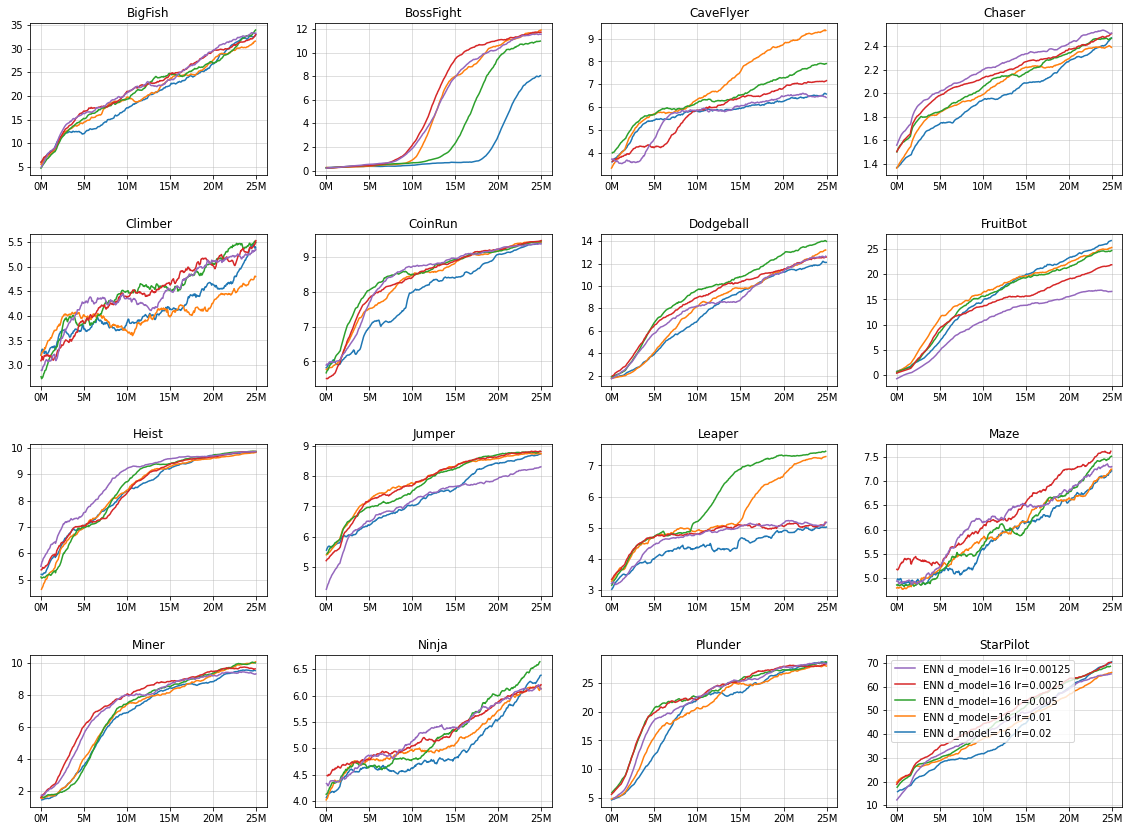

In [3]:
# Optimal lr=0.01
g = GridPlot(y_names=env_ids)
blocks = []
runsets = []

for env_id in env_ids:
    ex = expt.Experiment("Comparison of PPO")
    for lr in [0.02, 0.01, 0.005, 0.0025, 0.00125]:
        runset = Runset(
            name=f"ENN d_model={16} lr={lr}",
            filters={
                "$and": [
                    {"config.env.value.id": f"Procgen:{env_id}"},
                    {'created_at': {
                        "$gt": '2022-10-05T17'
                    }},
                    {"config.base_name": f"221212-135318-procgen-lrsweep-env={env_id}-lr={lr}"},
                ]
            },
            entity="cswinter",
            project="enn-ppo",
            groupby="base_name",
        )

        h = create_hypothesis(runset.name, runset.runs)
        ex.add_hypothesis(h)
    ex.plot(
        ax=g[env_id],
        title=env_id,
        # x="_runtime",
        x="global_step",
        y="episodic_reward.mean",
        err_style="band",
        std_alpha=0.1,
        rolling=50,
        n_samples=400,
        legend=False,
    )

g.add_legend(ax=g.axes[-1, -1], loc="upper left", bbox_to_anchor=(0, 1))
# Some post-processing with matplotlib API so that the plot looks nicer
for ax in g.axes_active:
    ax.xaxis.set_label_text("")
    ax.yaxis.set_label_text("")
# Nontransparent background
g.fig.patch.set_alpha(0)

plt.show()
# print("saving figure to test.png")
# plt.savefig("test.png")

BigFish


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


BossFight
CaveFlyer
Chaser
Climber
CoinRun
Dodgeball
FruitBot
Heist
Jumper


wandb: WARNING A graphql request initiated by the public wandb API timed out (timeout=9 sec). Create a new API with an integer timeout larger than 9, e.g., `api = wandb.Api(timeout=19)` to increase the graphql timeout.


Leaper
Maze
Miner
Ninja
Plunder
StarPilot


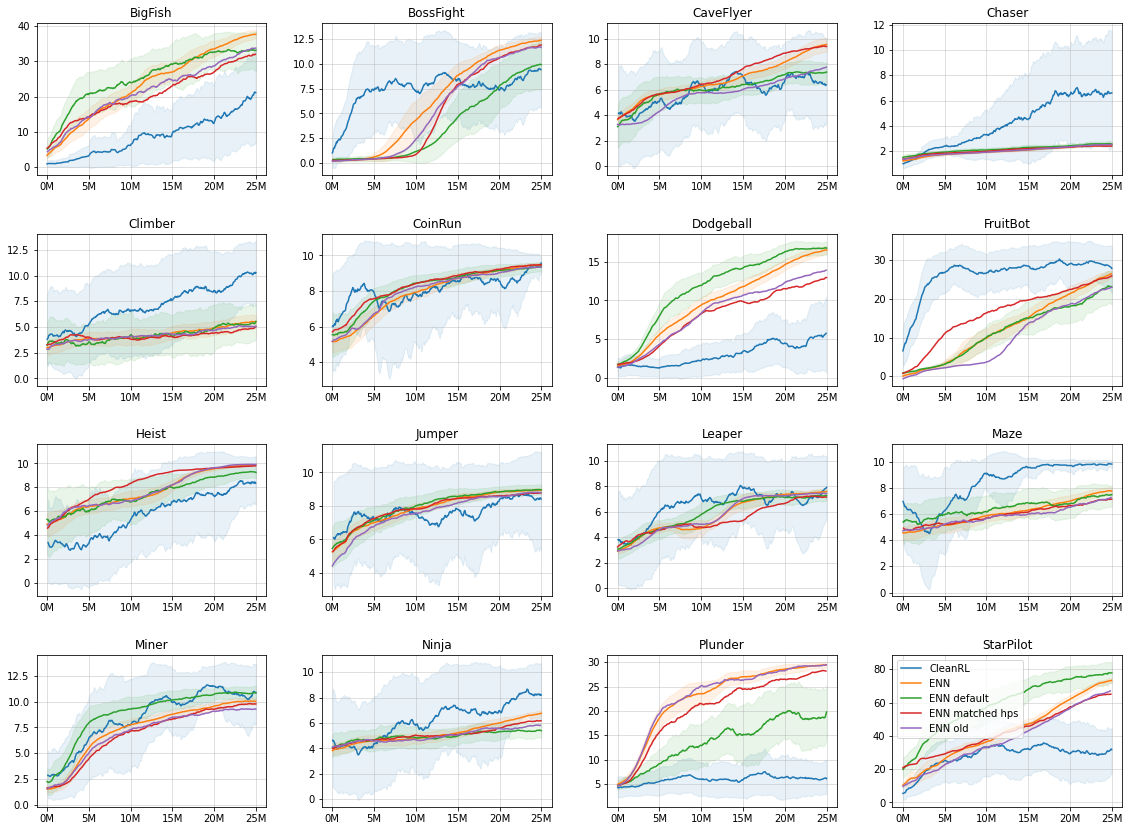

In [4]:

g = GridPlot(y_names=env_ids)
blocks = []

for env_id in env_ids:
    # NOTE: this is where to change things
    runset1 = Runset(
        name="CleanRL",
        filters={"$and": [{"config.env_id.value": env_id.lower()}, {"config.exp_name.value": "ppo_procgen"}]},
        entity="cswinter",
        project="cleanRL",
        groupby="env_id",
    )
    runset2 = Runset(
        name="ENN",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    # "$lt": '2022-03-09T10',
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221010-010215-procgen-baselines-mode=easy-env={env_id}"},
            ]
        },
        entity="entity-neural-network",
        project="enn-ppo",
        groupby="base_name",
    )
    runset3 = Runset(
        name="ENN default",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221102-152926-procgen-defaulthps-env={env_id}-mode=easy"},
            ]
        },
        entity="entity-neural-network",
        project="enn-ppo",
        groupby="base_name",
    )
    runset4 = Runset(
        name="ENN matched hps",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221212-135318-procgen-lrsweep-env={env_id}-lr=0.01"},
            ]
        },
        entity="cswinter",
        project="enn-ppo",
        groupby="base_name",
    )
    runset5 = Runset(
        name="ENN old",
        filters={
            "$and": [
                {"config.env.value.id": f"Procgen:{env_id}"},
                {'created_at': {
                    "$gt": '2022-10-05T17'
                }},
                {"config.base_name": f"221107-151146-procgen-basehps-env={env_id}-d=16-lr=0.01"}
            ]
        },
        entity="cswinter",
        project="enn-ppo",
        groupby="base_name",
    )

    ex = expt.Experiment("Comparison of PPO")
    h = create_hypothesis(runset1.name, runset1.runs)
    ex.add_hypothesis(h)
    print(env_id)
    h2 = create_hypothesis(runset2.name, runset2.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h2)
    h3 = create_hypothesis(runset3.name, runset3.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h3)
    h4 = create_hypothesis(runset4.name, runset4.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h4)
    h5 = create_hypothesis(runset5.name, runset5.runs, "episodic_reward.mean", "charts/episodic_return")
    ex.add_hypothesis(h5)
    ex.plot(
        ax=g[env_id],
        title=env_id,
        # x="_runtime",
        x="global_step",
        y="charts/episodic_return",
        err_style="band",
        std_alpha=0.1,
        rolling=50,
        n_samples=400,
        legend=False,
    )

g.add_legend(ax=g.axes[-1, -1], loc="upper left", bbox_to_anchor=(0, 1))
# Some post-processing with matplotlib API so that the plot looks nicer
for ax in g.axes_active:
    ax.xaxis.set_label_text("")
    ax.yaxis.set_label_text("")
# Nontransparent background
g.fig.patch.set_alpha(0)

plt.show()
# print("saving figure to test.png")
# plt.savefig("test.png")